<a href="https://colab.research.google.com/github/youngmoo/DSP_ColabUtils/blob/main/DSP_Plot_Utils.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction and motivation
This notebook contains code and examples for my simplified plotting and visualization utilities for basic signal processing in Colab.

* We enable interactive matplotlib figures (my thanks to [Brian McFee](https://brianmcfee.net), lead developer of [librosa](https://librosa.org), who showed me how to get this to work!)
* `myPlot` Basic signal plot with reasonable default settings
* `myPlotFFT` Basic frequency-domain magnitude response plot (in dB FS)
* `mySpectrogram` An easy spectrogram wrapper


# Initialization

## Install ipympl
This is needed to enable interactive matplotlib figures
* This installs packages that will require a restart of the runtime, so run this cell first.

In [1]:
!pip install ipympl   # Also installs a more recent version of matplot (v3.5.3)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 510 kB 5.2 MB/s 
     |████████████████████████████████| 11.2 MB 36.1 MB/s 
     |████████████████████████████████| 1.6 MB 39.9 MB/s 
     |████████████████████████████████| 957 kB 42.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


## Required package imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import IPython.display as ipd
from scipy import signal
import librosa
import soundfile as sf

# Enable interactive matplotlib figures

All credit to [Brian McFee](https://brianmcfee.net) for getting this to work so easily (surprising that Colab matplotlib doesn't enable this by default). With this, we can now support basic figure interaction:
* Pan
* Zoom in/out
* Display of cursor coordinates

In [2]:
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget

## My plotting style defaults (optional)
Nicer fonts for labels and custom background color.

In [3]:
rc('figure', figsize=(12,4))
rc('figure', facecolor='#aaaaaa')     # Better figure background for dark mode

rc('font', family='Liberation Serif') # Nicer font
rc('font', size=20)                   # Larger font size for labels

## Interactive figure example

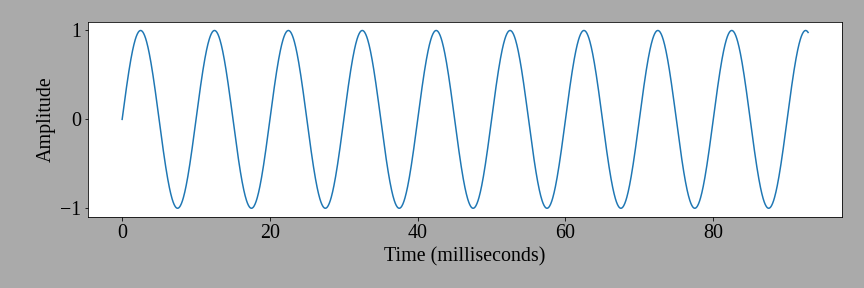

In [4]:
fs = 22050
t = np.arange(2048) / fs
f0 = 100
sine_signal = np.sin(2*np.pi*f0*t)  # Create a sine wave signal

fig = plt.figure(figsize=(12,4))    # New figure
plt.plot(t * 1000, sine_signal)     # Plot signal into current figure
plt.xlabel('Time (milliseconds)')
plt.ylabel('Amplitude')
fig.tight_layout()
plt.ion()                           # Turn on interactive plots

# **My Plot Helper Functions**

Load a demo music file (~60 seconds) to use in examples.

In [5]:
song, sr = librosa.load(librosa.util.example_audio_file())
print('Sample rate:', sr)
print('Duration (sec):', len(song)/sr)

Sample rate: 22050
Duration (sec): 61.45886621315193


## 1. myPlot
A quick time-domain signal plot function with my default figure settings and a time x-axis (in seconds).
* Required arguments:
  * `sig` Input signal (first argument)
* Optional arguments:
  * `N=#` Number of samples to plot (default: length of signal)
  * `fs=#` Sample rate of signal (default: 44100 Hz)
  * `fig_size=(W,H)` Change figure dimensions (width, height)
  * `x_ax=True/False` Show x-axis (default: True)
  * `y_ax=True/False` Show y-axis (default: True)
  * `lw=#` Change linewdith of signal (default: 1)
  * `fmt='...'` Plot format string (default: none)

In [6]:
def myPlot(sig, N=0, fs=44100, fig_size=(16,4), x_ax=True, y_ax=True, lw=1, fmt=''):
  if N==0:
    N = len(sig)

  fig = plt.figure(figsize=fig_size)
  t = np.arange(N)/fs
  plt.plot(t[:N],sig[:N],fmt,linewidth=lw)
  plt.xlabel('Time (sec)')
  ax = plt.gca()
  
  if x_ax == False:
    ax.xaxis.set_visible(False)
  if y_ax == False:
    ax.yaxis.set_visible(False)

  fig.tight_layout()
  plt.ion()

  # Returning the figure causes issues with interactive matplotlib
  #return fig
  # For saving the figure, use the interactive buton, instead.
  # For further customization and command-line saving, more changes are required.

### Example uses of myPlot

Plot the full song signal.

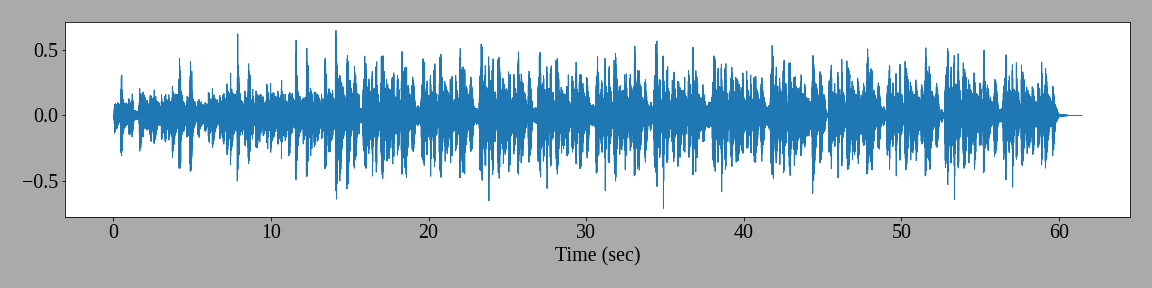

In [7]:
myPlot(song, fs=sr)

Plot just the first 22050 samples.

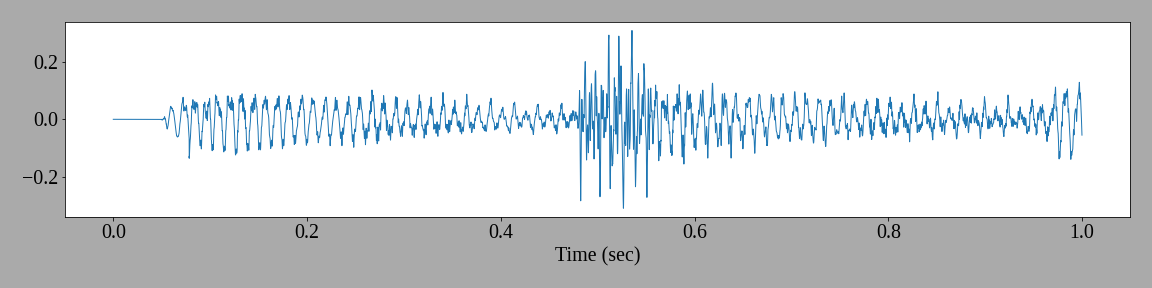

In [8]:
myPlot(song, N=22050, fs=sr)

Plot a clip of 2048 samples from the song as a green dashed line.

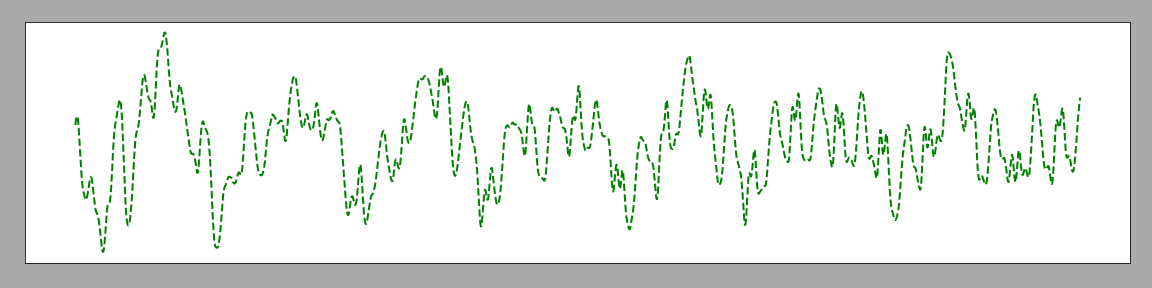

In [9]:
song_clip = song[100000:102048]
myPlot(song_clip, x_ax=False, y_ax=False, lw=2, fmt='g--')

## 2. myPlotFFT
Plot the magnitude frequency response (in dB FS) of a signal with my default figure settings and a frequency x-axis (in Hz), based on the Nyquist rate.
* Required arguments:
  * `sig` Input signal (first argument)
* Optional arguments:
  * `n_fft=#` The size of FFT to use (default: length of input signal)
  * `n_win=#` The length of Hann (hanning) window to use (default: length of input)
  * `fs=#` Sample rate of signal (default: 44100 Hz)
  * `x_lim=# or (#,#)` Frequency axis limits (max or range, in Hz)
  * `fig_size=(W,H)` Change figure dimensions (width, height)
  * `x_ax=True/False` Show x-axis (default: True)
  * `y_ax=True/False` Show y-axis (default: True)
  * `lw=#` Change linewdith of signal (default: 1)
  * `fmt='...'` Change plot formatting (default: none)

In [10]:
def myPlotFFT(sig, fs=44100, n_fft=0, n_win=0, x_lim=0, fig_size=(16,4),x_ax=True, y_ax=True, lw=1, fmt=''):
  if n_fft==0:
    n_fft = len(sig)
  if n_win==0:
    n_win = len(sig)  
  win = np.hanning(n_win)
  S = np.fft.fft(sig * win, n_fft)
  N = len(S)
  f = np.arange(N) * fs / N
  S_mag = 4*np.abs(S) / n_fft     # Frequency magnitude, normalized by length
                                  #    x2 because cos(w) = 0.5e^jw + 0.5e^-jw
                                  #    x2 because hanning window has 0.5 average
  S_mag += 0.0000001              # Add a small offset to avoid log(0) errors
  S_dBFS = 20*np.log10(S_mag)     # Freq. magnitude in dB full scale (dB FS):
                                  #    cos(w) -> 0 dBFS peak at w
  fig = plt.figure(figsize=fig_size)
  plt.plot(f, S_dBFS, fmt, linewidth=lw) 
  if np.isscalar(x_lim):
    if x_lim == 0:
      x_lim = fs/2
    plt.xlim(0, x_lim)
  else:
    plt.xlim(x_lim)
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Magnitude (dB)')

  ax = plt.gca()
  if x_ax == False:
    ax.xaxis.set_visible(False)
  if y_ax == False:
    ax.yaxis.set_visible(False)
  fig.tight_layout()

  # Returning the figure causes issues with interactive matplotlib
  #return fig
  # For saving the figure, use the interactive buton, instead.
  # For further customization and command-line saving, more changes are required.

### Example uses of myPlotFFT

Create a 1000 Hz sine signal and plot the frequency response.

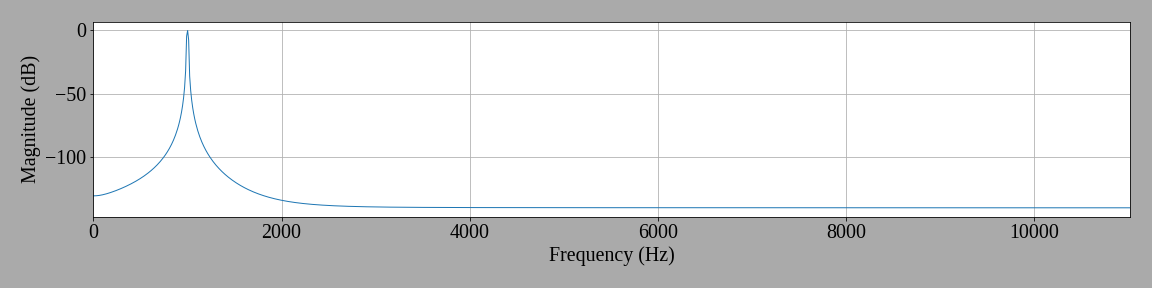

In [11]:
fs = 22050
t = np.arange(2048) / fs
f0 = 1000
sine_1000 = np.sin(2*np.pi*f0*t)  # Create a sine wave signal

myPlotFFT(sine_1000, fs=22050)
plt.grid(visible=True)            # Show a grid

Plot the frequency response of the demo song clip (2048 samples).

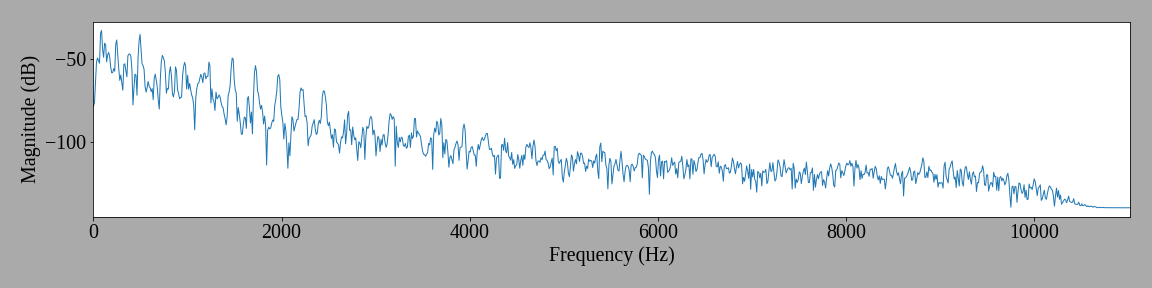

In [12]:
myPlotFFT(song_clip, fs=sr)

Zoom in on the song clip frequency response, from 500 to 5000 Hz.

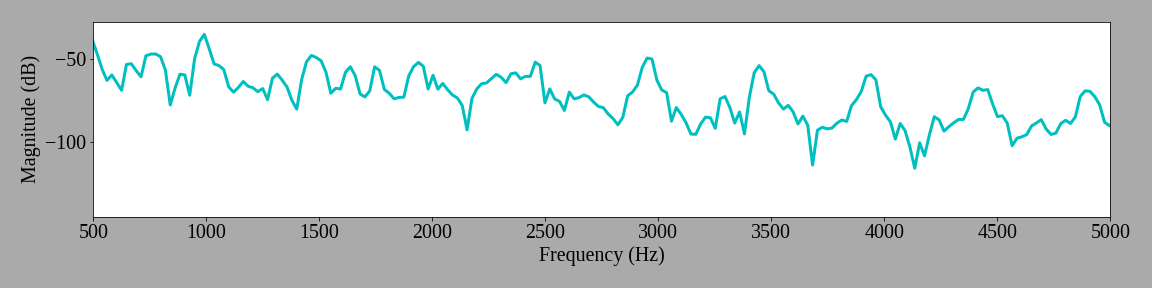

In [13]:
myPlotFFT(song_clip, x_lim=(500,5000), fmt='c', lw=3)

## mySpectrogram
A simple wrapper to compute and plot the spectrogram of a signal with my default figure settings, a time x-axis (in seconds) and a frequency y-axis (in Hz), based on the Nyquist rate.
* Required arguments:
  * `sig` Input signal (first argument)
* Optional arguments:
  * `fs=#` Sample rate of signal (default: 44100 Hz)
  * `win='window_name'` The type of analysis window to use (default: 'hann')
  * `n_win=#` The length of window to use per frame (default: 1024)
  * `n_fft=#` The size of FFT to use (default: 1024)
  * `x_lim=# or (#,#)` x-axis limit or range (in seconds)
  * `y_lim=# or (#,#)` y-axis limit or range (in Hz)
  * `fig_size=(W,H)` Change figure dimensions (width, height)
  * `x-ax=True/False` Show x-axis (default: True)
  * `y-ax=True/False` Show y-axis (default: True)

In [14]:
def mySpectrogram(sig, fs=44100, win='hann', n_win=1024, olap=512, n_fft=1024, x_lim=0, y_lim=0, fig_size=(12,6), x_ax=True, y_ax=True):
  f1, t1, Sxx = signal.spectrogram(sig, fs, window=win, nperseg=n_win, noverlap=olap, nfft=n_fft)

  fig = plt.figure(figsize=fig_size)
  S_mag = 4*np.abs(Sxx) + 0.0000000001    # See myPlotFFT for explanation
  S_dBFS = 20*np.log10(S_mag)
  plt.pcolormesh(t1, f1, S_dBFS)
  plt.ylabel('Frequency (Hz)')
  plt.xlabel('Time (sec)')

  if np.isscalar(x_lim):
    if x_lim == 0:
      x_lim = len(sig) / fs
    plt.xlim(0, x_lim)
  else:
    plt.xlim(x_lim)

  if np.isscalar(y_lim):
    if y_lim == 0:
      y_lim = fs/2
    plt.ylim(0, y_lim)
  else:
    plt.ylim(y_lim)

  ax = plt.gca()
  if x_ax == False:
    ax.xaxis.set_visible(False)
  if y_ax == False:
    ax.yaxis.set_visible(False)
  fig.tight_layout()

  plt.ion()
  
  # Returning the figure causes issues with interactive matplotlib
  #return fig
  # For saving the figure, use the interactive buton, instead.
  # For further customization and command-line saving, more changes are required.

### Examples using mySpectrogram

Create a chirp signal from 500 Hz to 5000 Hz (up and down) and display the spectrogram. 

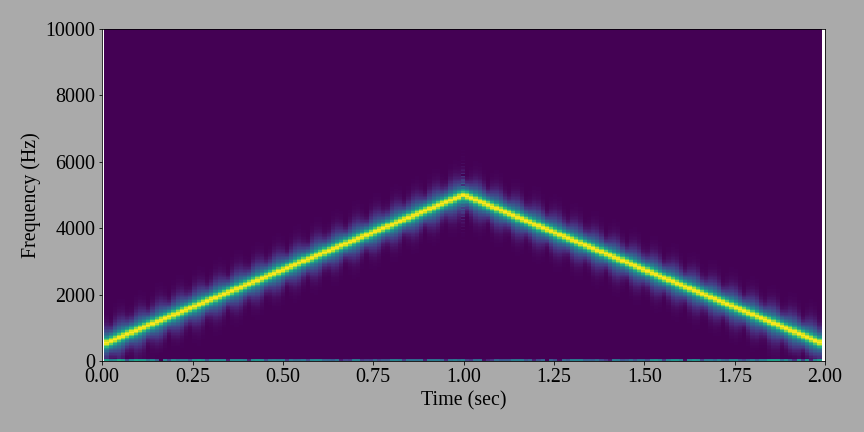

In [15]:
dur = 1       # Length of ramp in seconds (output is up & down, so final duration will be 2 * dur)
fs = 44100    # Sampling rate (22050 Hz)
f1 = 500      # Starting frequency (100 Hz)
f2 = 5000     # Highest frequency (1000 Hz)

t_up = np.arange(fs*dur) / fs
t_down = np.arange(fs*dur,fs*dur*2) / fs

f_up = (f2 - f1)/dur;
f_down = (f1 - f2)/dur;

chirp_up = np.sin(np.pi*f_up*t_up*t_up + 2*np.pi*f1*t_up);
chirp_down = np.sin(np.pi*f_down*t_down*t_down + 2*np.pi*(2*f2-f1)*t_down);

chirp = np.concatenate([chirp_up, chirp_down])

mySpectrogram(chirp, y_lim=10000)

Listen to the audio

In [16]:
ipd.Audio(chirp, rate=fs)

Spectrogram of first 10 seconds of demo song, displaying seconds 3 to 9.

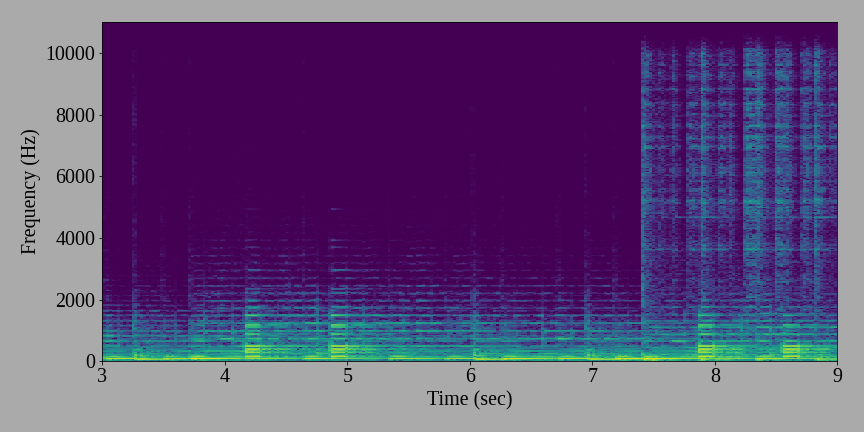

In [17]:
mySpectrogram(song[:10*sr], fs=sr, x_lim=(3,9))

Longer analysis window, more FFT points (higher frequency resolution), greater overlap between frames (7/8 of frame length).

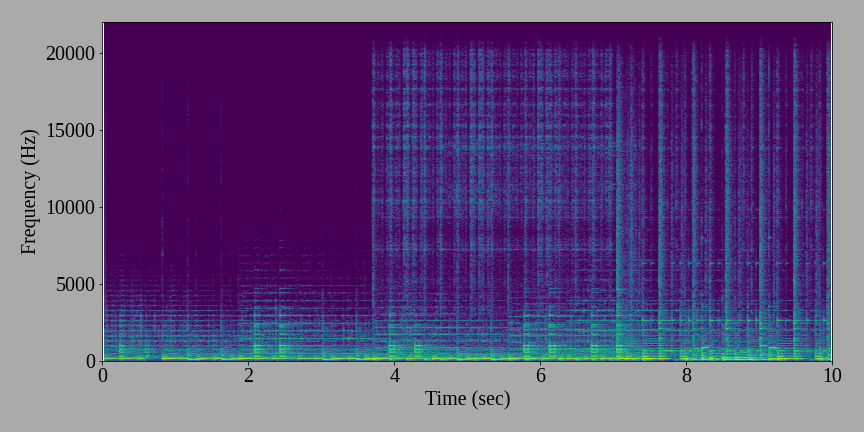

In [18]:
mySpectrogram(song[:10*fs], n_win=2048, n_fft=4096, olap=2048-256)

Change figure size, remove y-axis labels

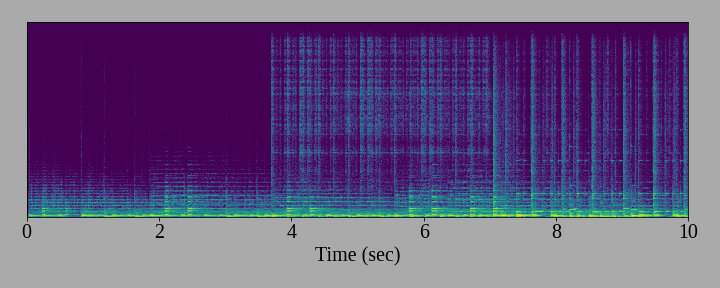

In [19]:
mySpectrogram(song[:10*fs], fig_size=(10,4), y_ax=False)